# Colour Magnitude Diagram

We read the photometric catalogs of the science frames, and draw a colour magnitude diagram.

You can download this page as a {download}`jupyter notebook <./CMD.ipynb>` file.

In [26]:
import dataredconfig

import numpy as np
import astropy
import astropy.table
import astropy.visualization
from astropy import units as u

%matplotlib widget
import matplotlib
from matplotlib import pyplot as plt

First we read the relevant catalogs as a list of tables.

In [27]:
# Where the photometry catalogs are:
photometry_dir = dataredconfig.work_dir / "PHOTOMETRY"

object_to_process = "M 37"

catalog_filepaths = sorted(list(photometry_dir.glob('*.fits')))
catalogs = []

for catalog_filepath in catalog_filepaths:
    
    catalog = astropy.table.Table.read(catalog_filepath)

    # We select the photometric catalogs of our object:  
    if "OBJECT" in catalog.meta:
        if catalog.meta["OBJECT"] == object_to_process:
            print(f"{catalog_filepath} : {catalog.meta}")
            catalogs.append(catalog)


/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/PHOTOMETRY/2024-03-08_22-04-34_r_-10.00_60.00s_0000.fits : OrderedDict([('DATE', '2024-04-22 20:37:12 CEST'), ('DATE-OBS', '2024-03-08T21:04:34.262'), ('EXPTIME', 60.0), ('IMAGETYP', 'LIGHT'), ('AIRMASS', 1.22797865344338), ('PIERSIDE', 'East'), ('FILTER', 'r'), ('OBJECT', 'M 37'), ('FOCUSPOS', 6773), ('FOCTEMP', 10.9), ('RA', 88.0599056676792), ('DEC', 32.5660643632296), ('SET-TEMP', -10.0), ('CCD-TEMP', -10.0), ('GAIN', 30), ('OFFSET', 30)])
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/PHOTOMETRY/2024-03-08_22-05-37_r_-10.00_60.00s_0001.fits : OrderedDict([('DATE', '2024-04-22 20:37:21 CEST'), ('DATE-OBS', '2024-03-08T21:05:37.675'), ('EXPTIME', 60.0), ('IMAGETYP', 'LIGHT'), ('AIRMASS', 1.23046486115206), ('PIERSIDE', 'East'), ('FILTER', 'r'), ('OBJECT', 'M 37'), ('FOCUSPOS', 6773), ('FOCTEMP', 10.9), ('RA', 88.0598757732892), ('DEC', 32.5660542777035), ('SET-TEMP', -10.0), ('CCD-TEMP', -10.0), ('GAIN', 30), ('OFFSET', 30)])
/U

Now we "merge" all these separate tables into a particular structure that will be very useful.

 * Measurements done with the same filter are stacked in "depth", i.e., grouped in 2D-columns.
 * Finally all filters are stacked "horizontally", i.e., as separate columns in one single table.

In [28]:

filter_names = ("g", "r", "i")
filter_catalogs = []

for filter_name in filter_names:
    #print(f"Starting filter {filter_name}")
    this_filter_catalogs = [catalog for catalog in catalogs if catalog.meta["FILTER"] == filter_name]
    this_filter_catalog = astropy.table.dstack(this_filter_catalogs, join_type="exact", metadata_conflicts="silent")
    this_filter_catalog.name = filter_name
    
    filter_catalogs.append(this_filter_catalog)

# And we stack these catalogs horizontally into one single table:
cat = astropy.table.hstack(filter_catalogs,
        join_type="exact", metadata_conflicts="silent",
        table_names=filter_names, uniq_col_name='{col_name}_{table_name}'
        )

# The column names are now:
print(cat.colnames)

['fwhm_4_g', 'elongation_4_g', 'sum_4_g', 'fwhm_6_g', 'elongation_6_g', 'sum_6_g', 'fwhm_8_g', 'elongation_8_g', 'sum_8_g', 'fwhm_4_r', 'elongation_4_r', 'sum_4_r', 'fwhm_6_r', 'elongation_6_r', 'sum_6_r', 'fwhm_8_r', 'elongation_8_r', 'sum_8_r', 'fwhm_4_i', 'elongation_4_i', 'sum_4_i', 'fwhm_6_i', 'elongation_6_i', 'sum_6_i', 'fwhm_8_i', 'elongation_8_i', 'sum_8_i']


In [29]:

# We add a column with the separation between each star and the cluster center.
# To get the position, we need to read the reference catalog:

ref_catalog = astropy.table.Table.read(photometry_dir / f"ref_catalog_{object_to_process}.fits")
assert len(ref_catalog) == len(cat) # Just a check that these are indeed of same length
    
cat["sky_pos"] = ref_catalog["sky_centroid_win"]
target_center_pos = astropy.coordinates.SkyCoord(cat.meta["RA"]*u.deg, cat.meta["DEC"]*u.deg)
cat["separation"] = astropy.coordinates.SkyCoord.separation(cat["sky_pos"], target_center_pos)


/var/folders/bn/kz374z7n0j1cvwxw41j9s_x80000gn/T/ipykernel_15605/2107606579.py:3: RuntimeWarning: invalid value encountered in log10
  cat["g"] = np.median(-2.5 * np.log10(cat["sum_4_g"].value), axis=1)
/var/folders/bn/kz374z7n0j1cvwxw41j9s_x80000gn/T/ipykernel_15605/2107606579.py:4: RuntimeWarning: invalid value encountered in log10
  cat["r"] = np.median(-2.5 * np.log10(cat["sum_4_r"].value), axis=1)


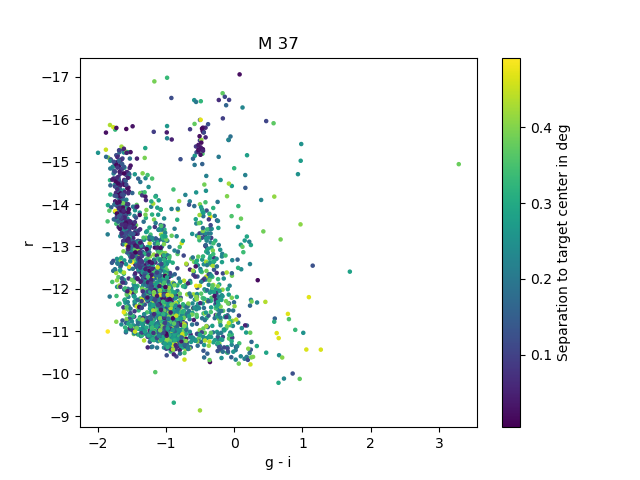

In [30]:
# Quick CMD, with a colorbar indicating the separation between each star and the cluster center

cat["g"] = np.median(-2.5 * np.log10(cat["sum_4_g"].value), axis=1)
cat["r"] = np.median(-2.5 * np.log10(cat["sum_4_r"].value), axis=1)
cat["i"] = np.median(-2.5 * np.log10(cat["sum_4_i"].value), axis=1)

plt.figure()
plt.scatter(
    cat["g"] - cat["i"],
    cat["r"],
    s = 5,
    c = cat["separation"].value
)
plt.gca().invert_yaxis()
plt.colorbar(label=f"Separation to target center in {cat['separation'].unit}")
plt.xlabel("g - i")
plt.ylabel("r")
plt.title(object_to_process)
plt.show()

